In [1]:
# bibliotecas
from dotenv import load_dotenv
import os
import duckdb
import pandas
import numpy
import unicodedata
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# estilo do seaborn
sns.set_style('whitegrid')

In [2]:
# carrega variáveis de ambiente
load_dotenv()
db_path = os.getenv('DUCKDB_PATH')

# inicia conexão com DuckDB
con = duckdb.connect(db_path)

In [3]:
# lançamentos de álbuns (não inclui singles, EPs, etc) lançados no Brasil entre 1955 e 2024
# quando o lançamento tem mais de um estilo/gênero, filtro somente a primeira informação
query = '''
    WITH genres AS (
        SELECT
            release_id,
            genre,
            ROW_NUMBER() OVER (PARTITION BY release_id) AS row_number
        FROM release_genre
    ),    
    styles AS (
        SELECT
            release_id,
            style,
            ROW_NUMBER() OVER (PARTITION BY release_id) AS row_number
        FROM release_style
    )    
    SELECT
        r.id,
        r.master_id,
        r.title,
        CAST(LEFT(r.released, 4) AS INT) AS year,
        g.genre,
        s.style,
        f.name AS format,
        f.descriptions AS format_desc
    FROM release AS r
    LEFT JOIN genres AS g ON g.release_id = r.id AND g.row_number = 1
    LEFT JOIN styles AS s ON s.release_id = r.id AND s.row_number = 1
    LEFT JOIN release_format AS f ON f.release_id = r.id
    WHERE
        r.country = 'Brazil'
        AND CAST(LEFT(r.released, 4) AS INT) BETWEEN 1955 AND 2024
        AND f.descriptions LIKE '%Album%'
'''

In [4]:
# abertura e visualização da base de lançamentos
df_releases = con.sql(query).df()

df_releases.head()

,id,master_id,title,year,genre,style,format,format_desc
0,188356,743534,Todos São Manos,1999,Hip Hop,Gangsta,CD,Album
1,197485,70499,World Power,1990,Electronic,Euro House,Vinyl,LP; Album
2,227369,12344,The Eminem Show,2002,Hip Hop,Pop Rap,CD,Album
3,227659,112271,Snoop Dogg Presents Tha Eastsidaz,2000,Hip Hop,Gangsta,CD,Album
4,450418,281028,V,1999,Rock,Alternative Rock,CD,Album; Reissue; Remastered


In [5]:
# informações de preenchimento da base
# "style" tem quantia considerável de missing :(
df_releases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104581 entries, 0 to 104580
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           104581 non-null  int64 
 1   master_id    104581 non-null  int64 
 2   title        104581 non-null  object
 3   year         104581 non-null  int32 
 4   genre        104581 non-null  object
 5   style        95060 non-null   object
 6   format       104581 non-null  object
 7   format_desc  104581 non-null  object
dtypes: int32(1), int64(2), object(5)
memory usage: 6.0+ MB


In [6]:
# cria "release_key": consiste em pegar o id da master (i.e. primeiro lançamento) e, quando não houver, pegar o id do próprio release
df_releases['release_key'] = df_releases['master_id'].where(df_releases['master_id'] != 0, df_releases['id'])

# filtra banco com apenas a primeira "release_key" de cada ano
df_first = df_releases.sort_values('year').groupby('release_key', as_index=False).first()

In [7]:
# função p/ limpar e padronizar preenchimento da variável "style"
def clean_string(string):

    string = unicodedata.normalize('NFKD', str(string)).encode('ASCII', 'ignore').decode('ASCII')
    string = string.lower()
    string = re.sub(r'[^\w\s]', '', string)
    string = re.sub(r'\s+', ' ', string).strip()
    
    return(string)

df_first['style_clean'] = df_first['style'].apply(clean_string)

In [8]:
# função p/ agrupar variável de estilo ("style")
# agrupamento da "genre" é muito genérico
def group_styles(style):

    if style == 'mpb':
        return 'MPB'
    
    if style == 'samba':
        return 'Samba'
    
    #if style in ['choro', 'axe']:
    #    return style.title()
    
    if re.search(r'bossa|jazz|latin|fusion|easy listening|big band', style):
        return 'Bossa Nova & Jazz'
    
    if re.search(r'forro|baiao', style):
        return 'Forró & Baião'
    
    if re.search(r'sertanejo|country|folk|blues|caipira|milonga', style) and not re.search('metal', style):
        return 'Sertanejo & Country'

    #if re.search(r'soundtrack|theme|score', style):
    #    return 'Trilhas Sonoras'
    
    #if re.search(r'rap|hip|hop|conscious', style) and not style == 'therapy':
    #    return 'Rap'
    
    #if re.search(r'reggae|dub', style):
    #    return 'Reggae'
    
    if style in ['pop rock', 'ballad', 'vocal', 'romantic', 'bolero', 'lambada'] or re.search(r'pop', style):
        return 'Pop & Romântico'

    if re.search(r'rock|punk|grunge|indie|surf', style) and not re.search('metal', style):
        return 'Rock'

    if re.search(r'metal|thrash|doom|core', style):
        return 'Metal'
    
    if re.search(r'gospel|religious', style):
        return 'Gospel'
       
    #if re.search(r'electro|synth|house|techno|trance', style):
    #    return 'Eletrônico'
    
    #if re.search(r'soul|rnb|rhythm.?blues|rb', style):
    #    return 'Soul & R&B'
    
    #if re.search(r'disco|funk|boogie|batucada|lambada', style):
    #    return 'Funk & Disco'
    
    #if re.search(r'classical|baroque', style):
    #    return 'Clássica'
    
    #if re.search(r'experimental|noise|industrial|abstract|contemporary', style):
    #    return 'Experimental'    
   
    return 'Outros'

df_first['style_grouped'] = df_first['style_clean'].apply(group_styles)

In [9]:
# verificando principais estilos (função anterior foca na criação de apenas 10)
top_styles = df_first['style_grouped'].value_counts(normalize=True) * 100
top_styles

style_grouped
Outros                 32.191382
Metal                  13.503456
Rock                   12.606934
MPB                     9.023492
Pop & Romântico         8.346797
Bossa Nova & Jazz       6.797415
Sertanejo & Country     6.427947
Samba                   5.388405
Gospel                  3.052414
Forró & Baião           2.661758
Name: proportion, dtype: float64

In [10]:
# indicador normalizado de importância dos estilos por ano:
# lançamentos do estilo X no ano Y / total de lançamentos no ano Y
rel_year = (
    df_first
    .groupby('year')
    .agg(total_releases=('id', 'nunique'))
    .reset_index()
)

rel_year_styles = (
    df_first
    .groupby(['year', 'style_grouped'])
    .agg(style_releases=('id', 'nunique'))
    .reset_index()
    .merge(rel_year, on='year')
    .assign(style_releases_p=lambda df: df['style_releases'] / df['total_releases'])
    .pivot(index='year', columns='style_grouped', values='style_releases_p')
)

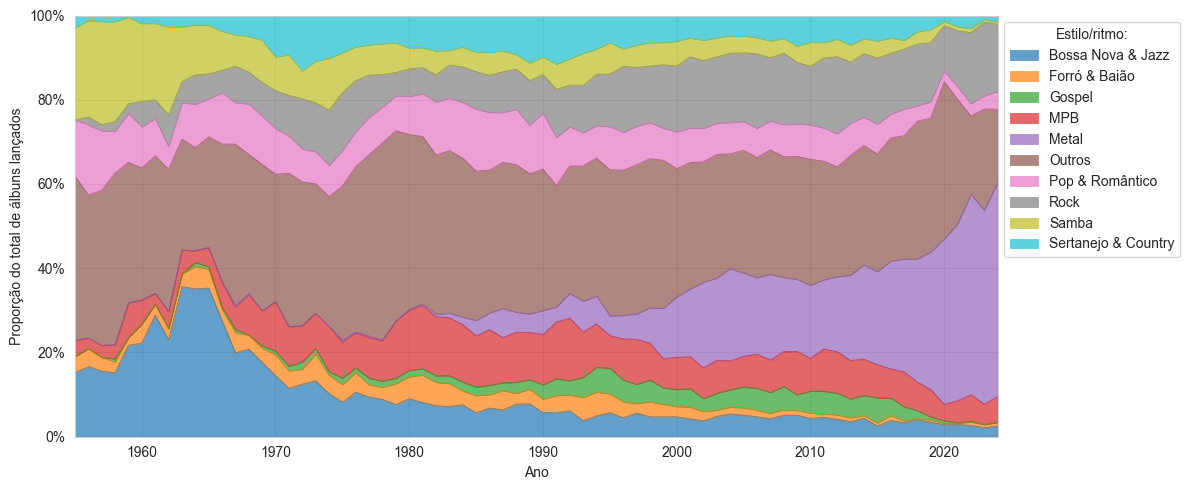

In [11]:
# plot de importância de cada estilo/ritmo ao longo do tempo
rel_year_styles.plot.area(
    figsize=(12, 5),
    stacked=True,
    color=sns.color_palette('tab10', n_colors=10),
    alpha=0.7,
    linewidth=0.5
)

plt.xlabel('Ano')
plt.ylabel('Proporção do total de álbuns lançados')
plt.legend(title='Estilo/ritmo:', bbox_to_anchor=(1, 1), loc='upper left')

plt.ylim(0, 1)
plt.xlim(1955, 2024)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(True, linestyle='-', linewidth=0.5, alpha=1)

plt.tight_layout()
plt.show()

In [34]:
# agrupamento da variável "format" para tipos comuns de produção
format_groups = {
    # CD/DVD/Blu-ray
    'CD': 'CD/DVD',
    'CDr': 'CD/DVD',
    'DVD': 'CD/DVD',
    'DVDr': 'CD/DVD',
    'Blu-ray': 'CD/DVD',
    
    # LP
    'Vinyl': 'LP/Vinil',
    'Lathe Cut': 'LP/Vinil',
    'Acetate': 'LP/Vinil',
    
    # Digital
    'File': 'Arquivo Digital',
    'Memory Stick': 'Arquivo Digital',
    'Floppy Disk': 'Arquivo Digital',
    
    # VHS/Cassete
    'Cassette': 'Fita VHS/Cassete',
    'VHS': 'Fita VHS/Cassete',
    '8-Track Cartridge': 'Fita VHS/Cassete'
}

df_first['format_grouped'] = df_first['format'].map(format_groups)
df_first['format_grouped'].value_counts()

format_grouped
CD/DVD              40227
LP/Vinil            29998
Arquivo Digital      3205
Fita VHS/Cassete     2011
Name: count, dtype: int64

In [36]:
# lançamentos por tipo de formato/produção ao longo do tempo
rel_year_formats = (
    df_first
    .groupby(['year', 'format_grouped'])
    .agg(releases=('id', 'nunique'))
    .reset_index()
)

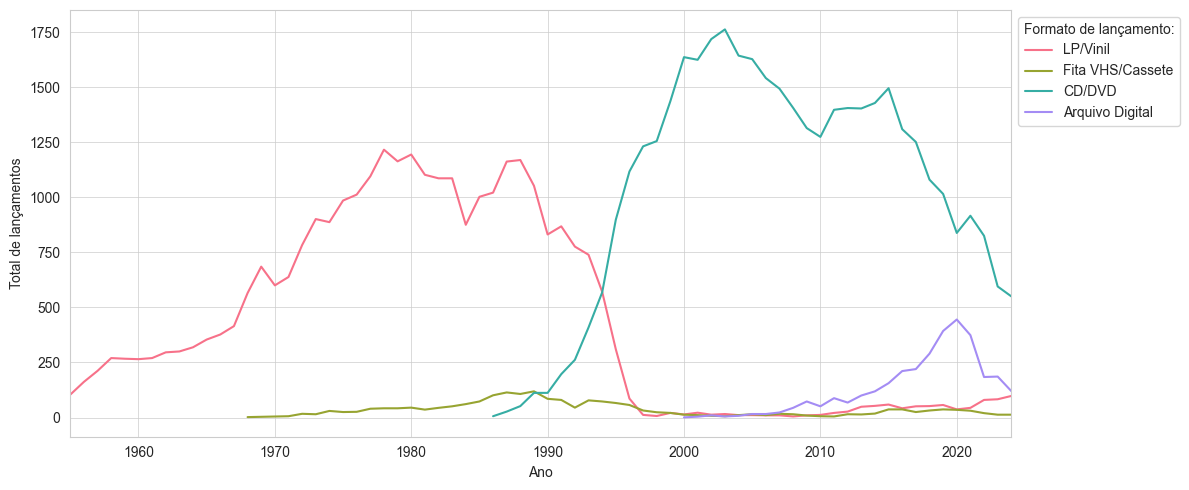

In [41]:
# plot de importância de cada formato ao longo do tempo
plt.figure(figsize=(12, 5))

sns.lineplot(
    data=rel_year_formats,
    x='year',
    y='releases',
    hue='format_grouped',
    palette='husl'
)

plt.xlabel('Ano')
plt.ylabel('Total de lançamentos')
plt.legend(title='Formato de lançamento:', bbox_to_anchor=(1, 1), loc='upper left')

plt.xlim(1955, 2024)

plt.grid(True, linestyle='-', linewidth=0.5, alpha=1)

plt.tight_layout()
plt.show()